In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import time
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
idxc = pd.read_csv('../task3/clean_data/clean_idxc.csv')
# 剩下的表用于训练和测试,来自inputs_process后的数据
y_pred = pd.read_csv('../task3/clean_data/clean_pred_process.csv')
y_true = pd.read_csv('../task3/clean_data/clean_true_process.csv')
rf = pd.read_csv('../task3/clean_data/clean_ortho_rf_process.csv')
factor_ret = pd.read_csv('../task3/clean_data/clean_factor_ret_process.csv')
y_true['stock_return']+=1
y_true = y_true.rename(columns = {'stock_return':'y_t'})

In [269]:
# 计时函数
def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s-= m*60
    return '%dm %ds' % (m,s)

In [365]:
# 建立actor网络，输入s，输出a
class get_actor(nn.Module):
    def __init__(self,state_dim,action_dim):
        super(get_actor,self).__init__()
        self.fc1 = nn.Linear(state_dim,32)
        self.fc2 = nn.Linear(32,action_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.tanh(x)
        # 为了保证权重之和为1，采用softmax函数转化
        x = self.softmax(x)
        return x

In [366]:
# 建立critic网络，输入s,a，输出Q值
class get_critic(nn.Module):
    def __init__(self,state_dim,action_dim):
        super(get_critic,self).__init__()
        self.fc1 = nn.Linear(state_dim+action_dim,256)
        self.fc2 = nn.Linear(256,32)
        self.fc3 = nn.Linear(32,1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(p=0.3)
        
        
    def forward(self,state,action):
        x = torch.cat([state,action], dim=1)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x 

In [367]:
# actor网络(目标在于最大化Q)的loss函数，DDPG算法中采用梯度上升更新
class a_loss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,q):
        a_loss = -q.mean(0)
        return a_loss

In [368]:
# 将四个网络actor,actor_target,critic,critic_target封装成一个类
class DDPG(object):
    def __init__(self,s_dim,a_dim,actor,actor_target,critic,critic_target,a_loss,device):
        
        self.memory = torch.zeros(memory_capacity,s_dim+a_dim+1+s_dim,dtype=torch.float32)
        self.pointer = 0
        self.s_dim,self.a_dim = s_dim,a_dim
        self.actor,self.actor_target = actor,actor_target
        self.critic,self.critic_target = critic,critic_target
        self.a_loss = a_loss
        
        # 初始时,actor_target的参数和actor的相同,critic_target的参数和critic的相同
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        # actor_target网络不训练，参数更新是由actor网络的参数赋值得到的(用滑动平均或隔一段时间更新一次)
        # critic_target网络同理
        self.actor_target.eval()
        self.critic_target.eval()
#         self.actor.train()
#         self.critic.train()
        
        # 选择device,能用gpu加速就用gpu加速
        self.device = device
        
        # 选择优化器
        self.actor_opt = torch.optim.Adam(self.actor.parameters(),lr=lr_a)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(),lr=lr_c)
        
        # 选择损失函数
        self.critic_criterion = nn.MSELoss().to(self.device)
        self.actor_criterion = self.a_loss().to(self.device)
    
    # policy函数
    def choose_action(self,s):
        return self.actor(s)
    
    # 存储数据元组(s,a,r,s_)作为训练集
    # 其中s表示当前状态的特征,a表示持仓权重向量，r表示当天的收益（调仓后），s_表示下一个state的特征
    def store_transition(self,s,a,r,s_):
        
        r = torch.tensor([r],dtype=torch.float32)
        transition = torch.cat([s,a,r,s_])
        index = self.pointer
        self.memory[index,:] = transition
        self.pointer +=1
    
    # 利用self.memory里面的训练集对四个网络进行参数更新
    def learn(self):
        
        # bs(batch_state),ba(batch_action)
        # br(batch_reward),bs_(batch_next_state)
        bs = self.memory[:,:self.s_dim].detach()
        ba = self.memory[:,self.s_dim:self.s_dim + self.a_dim].detach()
        br = self.memory[:,-self.s_dim-1:-self.s_dim].detach()
        bs_ = self.memory[:,-self.s_dim:].detach()
       
        # critic网络更新
        a_  = self.actor_target(bs_)
        q_ = self.critic_target(bs_,a_)
        y = br + gamma * q_
        q = self.critic(bs,ba)
        critic_loss = self.critic_criterion(y,q)
        self.critic_opt.zero_grad()
        critic_loss.backward(retain_graph=True)
        self.critic_opt.step()
            
        # actor网络更新
        a = self.actor(bs)
        q2 = self.critic(bs,a)
        actor_loss = self.actor_criterion(q2)
        self.actor_opt.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor_opt.step()
     
        # 滑动平均更新critic_target,actor_target网络
        c_dict = self.critic.state_dict()
        c_key = list(c_dict.keys())
        ct_dict = self.critic_target.state_dict()
        a_dict = self.actor_target.state_dict()
        a_key = list(a_dict.keys())
        at_dict = self.actor_target.state_dict()
        for c in c_key:
            ct_dict[c] = ct_dict[c]*decay+c_dict[c]*(1-decay)
        for a in a_key:
            at_dict[a] = at_dict[a]*decay+a_dict[a]*(1-decay)
        self.critic_target.load_state_dict(ct_dict)
        self.actor_target.load_state_dict(at_dict)

In [369]:
# 计算交易折扣因子,其中df的格式见step函数中的定义
# c1=滑点+佣金带来的损失率，c2=税金带来的损失率
# 这对应于带现金情形，用于计算index_component表按weight持仓得到的收益
def get_mu_cash(df,c1,c2):
    
    def relu(x):
        if x>=0:
            return x
        else:
            return 0
    
    def function_mu(df,c1,c2,mu):
        sigma = 0
        for i in range(1,len(df)):
            sigma+=relu(df['wt_prime'].iloc[i]-mu*df['w_t'].iloc[i])
        numerator = 1+c1-c1*df['wt_prime'].iloc[0]-(2*c1+c2)*sigma
        denominator = 1+c1-c1*df['w_t'].iloc[0]
        return numerator/denominator

    
    mu_list=[]
    eps = 1e-15
    delta = 1
    mu = 1
    mu_list.append(mu)
    while delta>eps:
        mu = function_mu(df,c1,c2,mu)
        mu_list.append(mu)
        delta = abs(mu_list[-1]-mu_list[-2])
    
    return mu

In [370]:
# 计算交易折扣因子,其中df的格式见step函数中的定义
# c1=滑点+佣金带来的损失率，c2=税金带来的损失率
# 这对应于不带现金情形，用于计算模型训练
def get_mu(df,c1,c2):
    
    def relu(x):
        if x>=0:
            return x
        else:
            return 0
    
    def function_mu(df,c1,c2,mu):
        sigma = 0
        for i in range(1,len(df)):
            sigma+=relu(df['wt_prime'].iloc[i]-mu*df['w_t'].iloc[i])
        numerator = 1+c1-(2*c1+c2)*sigma
        denominator = 1+c1
        return numerator/denominator

    
    mu_list=[]
    eps = 1e-15
    delta = 1
    mu = 1
    mu_list.append(mu)
    while delta>eps:
        mu = function_mu(df,c1,c2,mu)
        mu_list.append(mu)
        delta = abs(mu_list[-1]-mu_list[-2])
    
    return mu

In [371]:
# 模型训练时的step函数，主要功能为计算每一步的回报
# w_before为trade_date的前一天的持仓权重
# w_after为trade_date当天调整仓位后的持仓权重
# w_before,w_after都以stock_code为index
def step(trade_date,y_true,w_before,w_after):
    
    date_yt = y_true[y_true['trade_date']==trade_date].set_index('stock_code')['y_t']
    w_before = w_before.rename('w_t-1')
    w_after = w_after.rename('w_t')
    df = pd.concat([date_yt,w_before,w_after],axis=1,join='outer')
    df = df.fillna(0)
    df['wt_prime']=(df['y_t']*df['w_t-1'])/((df['y_t']*df['w_t-1']).sum())
    # 选择不带现金项的交易折扣因子函数
    mu = get_mu(df,c1=0.0012+0.00015,c2=0.001)
    reward = np.log(mu)+np.log((df['y_t']*df['w_t-1']).sum())
    next_trade_date = trade_date+1
    
    return next_trade_date,reward

In [372]:
# 带现金项的step函数
def step_cash(trade_date,y_true,w_before,w_after):
    
    date_yt = y_true[y_true['trade_date']==trade_date].set_index('stock_code')['y_t']
    w_before = w_before.rename('w_t-1')
    w_after = w_after.rename('w_t')
    df = pd.concat([date_yt,w_before,w_after],axis=1,join='outer')
    df = df.fillna(0)
    df['wt_prime']=(df['y_t']*df['w_t-1'])/((df['y_t']*df['w_t-1']).sum())
    # 选择带现金项的交易折扣因子函数
    mu = get_mu_cash(df,c1=0.0012+0.00015,c2=0.001)
    reward = np.log(mu)+np.log((df['y_t']*df['w_t-1']).sum())
    next_trade_date = trade_date+1
    
    return next_trade_date,reward

In [373]:
# 提取状态s的特征，数据类型为tensor
def features(trade_date,y_true,y_pred):
    score = torch.tensor(y_pred[y_pred['trade_date']==trade_date]['score'].values,dtype=torch.float32)
#     y_t = torch.tensor(y_true[y_true['trade_date']==trade_date-1]['y_t'].values,dtype=torch.float32)
#     features = torch.cat([score,y_t])
    features = score
    s_dim = features.shape[0]
    return features,s_dim

In [374]:
def get_average_policy(n,y_pred,y_true):
    average_policy = pd.DataFrame()
    date_idx = np.sort(np.array(list(set(y_true['trade_date']))))
    for date in date_idx:
        # 首先保证y_pred表中的候选stock_code在y_true表中都有
        set1 = set(y_true[y_true['trade_date']==date]['stock_code'])
        set2 = set(y_pred[y_pred['trade_date']==date]['stock_code'])
        candidate_stock_code = list(set1 & set2)
        # 排序得到score在前n名的股票的stock_code
        temp = y_pred[y_pred['trade_date']==date]
        temp = temp[temp['stock_code']==candidate_stock_code]
        temp = temp.sort_values('score',ascending=False).iloc[0:n]['stock_code']
        first_n_stock_code = np.sort(np.array(list(set(temp))))
        temp2 = {
                "trade_date":list((np.ones(n)*date).astype(int)),
                "stock_code":first_n_stock_code,
                "weight":list((np.ones(n)/n).astype(float))
                }
        temp2 = pd.DataFrame(temp2)
        average_policy = pd.concat([average_policy,temp2],axis=0)
    return average_policy

In [375]:
# 把stock_return调整为前后两天的价格比，并加入现金部分，记为stock_code=-1
def add_cash(y_true):
    date_idx = np.sort(np.array(list(set(y_true['trade_date']))))
    y_true['stock_return']+=1
    y_true = y_true.rename(columns={'stock_return':'y_t'})
    for date in date_idx:
        cash = pd.DataFrame({'trade_date':[date],'stock_code':[-1],'y_t':[1]})
        y_true = pd.concat([y_true,cash],axis=0,ignore_index=True)
    y_true = y_true.sort_values(['trade_date','stock_code'])
    y_true.index = range(len(y_true))
    return y_true

In [376]:
# 对持仓权重表进行结构化（对不持仓的股票的weight补零，并添加现金部分）
# y_true要带现金项
def struct(df_weight,y_true):
    date_idx = np.sort(np.array(list(set(df_weight['trade_date']))))
    new_df_weight = pd.DataFrame()
    for date in date_idx:
        temp = df_weight[df_weight['trade_date']==date].set_index('stock_code')
        temp2 = y_true[y_true['trade_date']==date].set_index('stock_code')
        # 对不持仓的股票的weight补零
        temp3 = pd.concat([temp,temp2],axis=1,join='outer').iloc[:,:2].fillna(0)
        temp3['trade_date'] = date
        temp3 = temp3.reset_index()
        # 添加现金项
        temp3.loc[0,'weight'] = 1-temp3[temp3['stock_code']!=-1]['weight'].sum()
        new_df_weight = pd.concat([new_df_weight,temp3],axis=0)
    return new_df_weight

In [377]:
# 计算带现金项的超额收益
def excess_return(df_weight1,df_weight2,y_true):
    rlist = []
    date_idx = np.sort(np.array(list(set(df_weight1['trade_date']) & set(df_weight2['trade_date']))))
    date_idx = date_idx[1:]
    for date in date_idx:
        w1_before = df_weight1[df_weight1['trade_date']==date-1].set_index('stock_code')['weight']
        w1_after = df_weight1[df_weight1['trade_date']==date].set_index('stock_code')['weight']
        _,r1 = step_cash(date,y_true,w1_before,w1_after)
        w2_before = df_weight2[df_weight2['trade_date']==date-1].set_index('stock_code')['weight']
        w2_after = df_weight2[df_weight2['trade_date']==date].set_index('stock_code')['weight']
        _,r2 = step_cash(date,y_true,w2_before,w2_after)
        rlist.append(r1-r2)
    return rlist

In [378]:
# 计算日均超额收益和年化超额收益
def ex_ret_mean_annul(ex_ret):
    ex_ret_mean = np.array(ex_ret).mean()
    ex_ret_annul = np.power((1+ex_ret_mean),252)-1
    return ex_ret_mean,ex_ret_annul

In [379]:
code_idx = np.sort(np.array(list(set(y_true['stock_code']))))
date_idx = np.sort(np.array(list(set(y_true['trade_date']))))
start_date = date_idx[1]       # 从第二天开始使用模型所选择的持仓
_,s_dim = features(start_date,y_true,y_pred) # 状态s的维数
a_dim = len(code_idx) # 行动a的维数
# 超参数表
lr_a = 0.001          # actor网络的学习率
lr_c = 0.002          # critic网络的学习率
decay = 0.99          # targer网络滑动更新的超参数
gamma = 0.8           # 总reward函数中的超参数gamma
max_episodes = 20     # 训练次数
max_ep_steps = 200    # 前200天的数据用于训练
memory_capacity = max_ep_steps  # 每次都拿前200天的数据来训练

In [380]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DDPG算法中要建立4个网络
actor = get_actor(s_dim,a_dim)
actor_target = get_actor(s_dim,a_dim)
critic = get_critic(s_dim,a_dim)
critic_target = get_critic(s_dim,a_dim)
ddpg = DDPG(s_dim,a_dim,actor,actor_target,critic,critic_target,a_loss,device)

In [381]:
# 训练模型
reward_buffer = []   # 记录每次训练后得到的reward
code_idx = np.sort(np.array(list(set(y_true['stock_code']))))
start_time  = time.time()
# DDPG属于off-policy--先用策略生成训练数据（s,a,r,s_),再用这些训练数据更新策略
for i in range(max_episodes):
    date = start_date
    ep_reward = 0
    action_list = []
    # 设第一天的持仓权重为等分情形
    action_list.append(np.ones(a_dim,dtype=np.float32)/a_dim)
    ddpg.actor.eval()
    ddpg.critic.eval()
    for j in range(max_ep_steps):
        s,_ = features(date,y_true,y_pred)
        a = ddpg.choose_action(s.unsqueeze(0))
        action_list.append(a.squeeze(0).detach().numpy())
        # 构造weight表
        w_before = pd.DataFrame({'weight':action_list[-2],'stock_code':code_idx})
        w_before = w_before.set_index('stock_code')['weight']
        w_after = pd.DataFrame({'weight':action_list[-1],'stock_code':code_idx})
        w_after = w_after.set_index('stock_code')['weight']
        next_date,r = step(date,y_true,w_before,w_after)
        s_,_ = features(next_date,y_true,y_pred)
        ddpg.store_transition(s,a.squeeze(0),r,s_)
        date = next_date
        ep_reward += r
        date = next_date
        j+=1
    
    reward_buffer.append(ep_reward)
    
    ddpg.actor.train()
    ddpg.critic.train()
    ddpg.learn()
    ddpg.pointer = 0
    print('已完成%d/%d,用时%s' % (i+1,max_episodes,timeSince(start_time)))

已完成1/20,用时0m 27s
已完成2/20,用时0m 54s
已完成3/20,用时1m 22s
已完成4/20,用时1m 51s
已完成5/20,用时2m 19s
已完成6/20,用时2m 46s
已完成7/20,用时3m 14s
已完成8/20,用时3m 42s
已完成9/20,用时4m 9s
已完成10/20,用时4m 36s
已完成11/20,用时5m 4s
已完成12/20,用时5m 31s
已完成13/20,用时5m 58s
已完成14/20,用时6m 25s
已完成15/20,用时6m 53s
已完成16/20,用时7m 19s
已完成17/20,用时7m 46s
已完成18/20,用时8m 13s
已完成19/20,用时8m 40s
已完成20/20,用时9m 7s


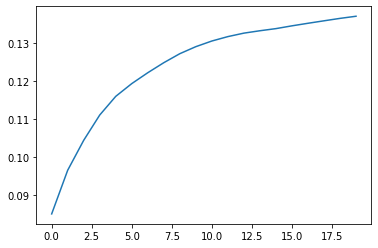

In [382]:
plt.plot(reward_buffer)
plt.show()

In [383]:
# 测试模型
ddpg.actor.eval()
ddpg.critic.eval()
test_date = date_idx[-100:]
test_action_list = []
for date in test_date:
    s,_ = features(date,y_true,y_pred)
    a = ddpg.choose_action(s.unsqueeze(0))
    test_action_list.append(a.squeeze(0).detach().numpy())
    
# 构造test_action_list对应的dataframe
test_df = pd.DataFrame()
for i,date in enumerate(test_date):
    temp = pd.DataFrame({'trade_date':[date]*len(code_idx),'stock_code':code_idx,'weight':test_action_list[i]})
    test_df = pd.concat([test_df,temp],axis=0)
    
# 检查权重之和是否为1（或者非常接近1）
weight_sum = []
for date in test_date:
    weight_sum.append(test_df[test_df['trade_date']==date]['weight'].sum())
print(min(weight_sum),max(weight_sum))

0.99999976 1.0000002


In [384]:
# 使用inputs_process前的y_true和y_pred构造baseline
y_true2 = pd.read_csv('../task3/clean_data/clean_true.csv')
y_pred2 = pd.read_csv('../task3/clean_data/clean_pred.csv')
idxc = pd.read_csv('../task3/clean_data/clean_idxc.csv')

In [385]:
test_date_idx = np.sort(np.array(list(set(test_df['trade_date']) & set(idxc['trade_date']))))

In [386]:
y_true2 = add_cash(y_true2) # 给y_true加现金项
idxc = struct(idxc,y_true2)
test_df = struct(test_df,y_true2)

99天的日均超额收益:-0.0002 	 年化超额收益:-0.0472


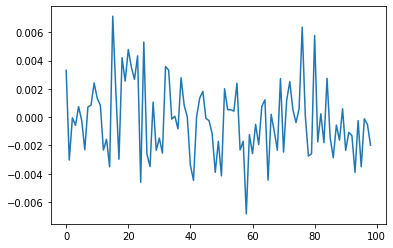

In [387]:
# 计算模型的超额收益
rlist = excess_return(test_df,idxc,y_true2)
rmean,rannul = ex_ret_mean_annul(rlist)
plt.plot(rlist)
print("%d天的日均超额收益:%.4f \t 年化超额收益:%.4f" % (len(rlist),rmean,rannul))

In [394]:
np.array(rlist).mean()/np.array(rlist).std()

-0.0734845987230876

In [231]:
# 和按score选取前n名并平均持仓的策略做对比
policy = get_average_policy(1200,y_pred2,y_true2)
# policy = policy[policy['trade_date']>=test_date_idx[0]]
policy = struct(policy,y_true2)

99天的日均超额收益:0.0001 	 年化超额收益:0.0301


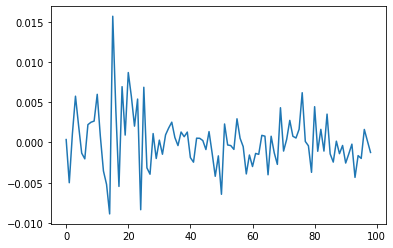

In [232]:
# 计算baseline的超额收益
base_rlist =  excess_return(policy,idxc,y_true2)
base_rlist = base_rlist[-99:]
base_rmean,base_rannul = ex_ret_mean_annul(base_rlist)
plt.plot(base_rlist)
print("%d天的日均超额收益:%.4f \t 年化超额收益:%.4f" % (len(base_rlist),base_rmean,base_rannul))

In [396]:
np.array(base_rlist).mean()/np.array(base_rlist).std()

0.03374043113153632